In [4]:
# Import standard libraries and configure display options
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make sure all columns are visible when inspecting the DataFrame
pd.set_option("display.max_columns", None)

# Path to the dataset (assuming it’s in the same folder as this notebook)
CSV_PATH = "Chicago_Shooting_Dataset.csv"


In [5]:
# Load the dataset and apply light cleaning for consistency
df = pd.read_csv(CSV_PATH, low_memory=False)

# Standardize text columns to uppercase to avoid category duplicates
def to_upper_strip(s):
    try:
        return s.astype(str).str.upper().str.strip()
    except Exception:
        return s

for col in ["Primary Type", "Description", "Location Description"]:
    if col in df.columns:
        df[col] = to_upper_strip(df[col])

# Parse any available date column and create time-related fields
dt_col = next((c for c in ["date_standardized", "Date", "DATE", "Incident Date", "INCIDENT_DATE"] if c in df.columns), None)
if dt_col:
    df["_dt"] = pd.to_datetime(df[dt_col], errors="coerce", infer_datetime_format=True)
    df["year"] = df["_dt"].dt.year
    df["month"] = df["_dt"].dt.month
    df["day_of_week"] = df["_dt"].dt.day_name()
    df["hour"] = df["_dt"].dt.hour
else:
    df["_dt"] = pd.NaT

# Display shape and a few sample rows to confirm data integrity
display(df.shape)
display(df.head(3))


C:\Users\Administrator\AppData\Local\Temp\ipykernel_3764\281022142.py:18: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["_dt"] = pd.to_datetime(df[dt_col], errors="coerce", infer_datetime_format=True)


(1723, 17)

ID Case Number                 Date Location Description  Arrest  \
0  13894362    JJ326433  2025-07-08 20:13:00               STREET    True   
1  13893362    JJ325283  2025-07-08 01:56:00          GAS STATION   False   
2  13891960    JJ323643  2025-07-06 19:58:00        PARK PROPERTY    True   

   Domestic  Beat  District  Ward  Community Area   Latitude  Longitude  \
0     False   111         1    42              32  41.888104 -87.625549   
1     False   424         4     7              46  41.744647 -87.552238   
2     False  1915        19    46               3  41.962412 -87.634908   

                  _dt  year  month day_of_week  hour  
0 2025-07-08 20:13:00  2025      7     Tuesday    20  
1 2025-07-08 01:56:00  2025      7     Tuesday     1  
2 2025-07-06 19:58:00  2025      7      Sunday    19

ID                      0
Case Number             0
Date                    0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
Latitude                0
Longitude               0
_dt                     0
year                    0
month                   0
day_of_week             0
hour                    0
dtype: int64

count          mean            std           min  \
ID              1723.0  1.262541e+07  555732.005678  7.177217e+06   
Beat            1723.0  9.600592e+02     637.888348  1.110000e+02   
District        1723.0  9.367963e+00       6.373887  1.000000e+00   
Ward            1723.0  1.855427e+01      12.040960  1.000000e+00   
Community Area  1723.0  4.474811e+01      20.117377  1.000000e+00   
Latitude        1723.0  4.180799e+01       0.085023  4.164461e+01   
Longitude       1723.0 -8.765571e+01       0.062951 -8.790646e+01   
year            1723.0  2.021557e+03       1.582629  2.009000e+03   
month           1723.0  6.465467e+00       3.210636  1.000000e+00   
hour            1723.0  1.085374e+01       8.403899  0.000000e+00   

                         25%           50%           75%           max  \
ID              1.217114e+07  1.248890e+07  1.304044e+07  1.389436e+07   
Beat            6.110000e+02  6.330000e+02  1.411000e+03  2.535000e+03   
District        6.000000e+00  6.000000e+00  1.400000e+01  2.500000e+01   
Ward            8.000000e+00  1.700000e+01  2.700000e+01  5.000000e+01   
Community Area  2.700000e+01  4.400000e+01  6.650000e+01  7.700000e+01   
Latitude        4.174536e+01  4.176649e+01  4.188019e+01  4.202178e+01   
Longitude      -8.769865e+01 -8.764897e+01 -8.761189e+01 -8.752924e+01   
year            2.020000e+03  2.021000e+03  2.023000e+03  2.025000e+03   
month           4.000000e+00  6.000000e+00  9.000000e+00  1.200000e+01   
hour            2.000000e+00  1.100000e+01  1.900000e+01  2.300000e+01   

                      median  
ID              1.248890e+07  
Beat            6.330000e+02  
District        6.000000e+00  
Ward            1.700000e+01  
Community Area  4.400000e+01  
Latitude        4.176649e+01  
Longitude      -8.764897e+01  
year            2.021000e+03  
month           6.000000e+00  
hour            1.100000e+01

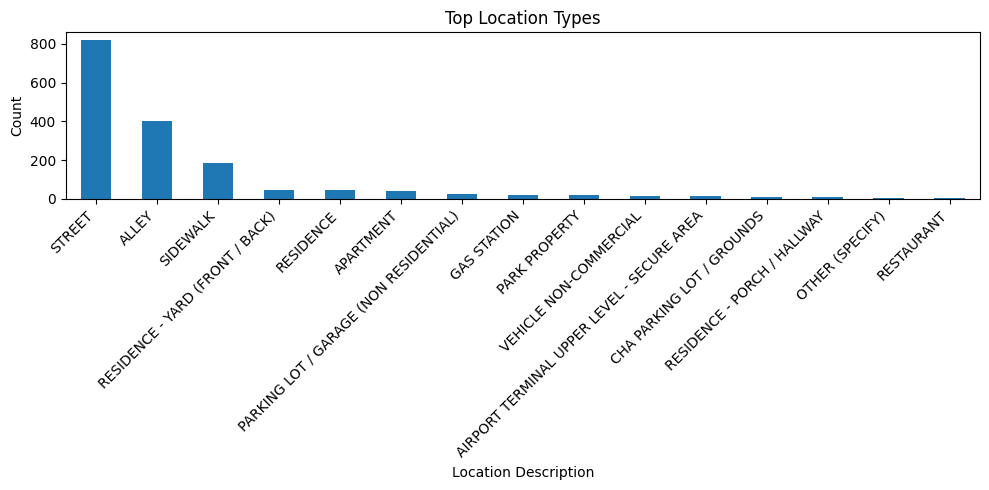

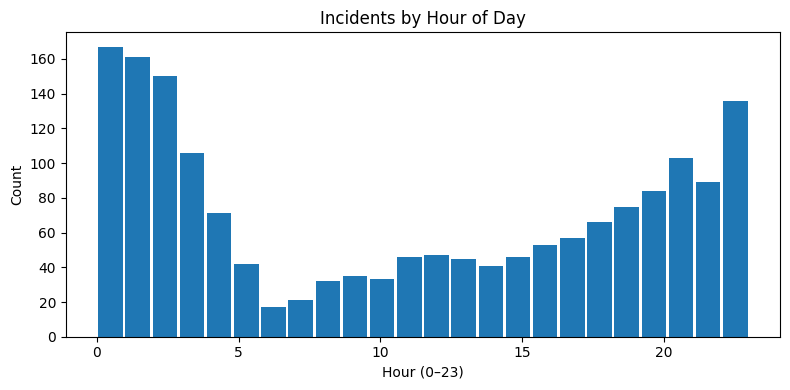

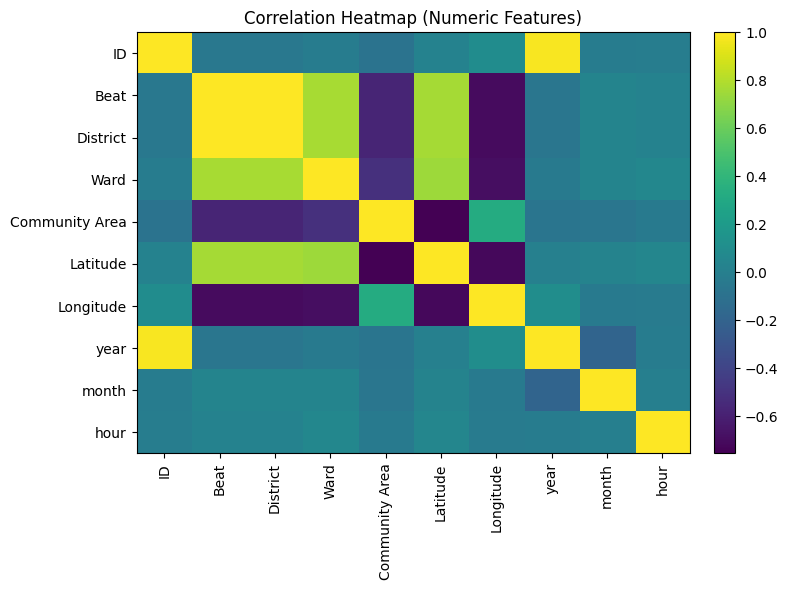

In [7]:
# Generate summary statistics and inspect missing values
missing_counts = df.isna().sum().sort_values(ascending=False)
display(missing_counts.head(20))

numeric_df = df.select_dtypes(include=[np.number])
num_summary = numeric_df.describe().T
num_summary["median"] = numeric_df.median(numeric_only=True)
display(num_summary.head(20))

# Plot the most common location types
if "Location Description" in df.columns:
    s = df["Location Description"].value_counts().head(15)
    if len(s) > 0:
        plt.figure(figsize=(10, 5))
        s.plot(kind="bar")
        plt.title("Top Location Types")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# Plot the hourly distribution of incidents
if "hour" in df.columns and df["hour"].notna().any():
    plt.figure(figsize=(8, 4))
    df["hour"].dropna().astype(int).plot(kind="hist", bins=24, rwidth=0.9)
    plt.title("Incidents by Hour of Day")
    plt.xlabel("Hour (0–23)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Extract and visualize weapon types from the description column
weapon_patterns = {
    "HANDGUN": r"\bHANDGUN\b",
    "RIFLE": r"\bRIFLE\b",
    "SHOTGUN": r"\bSHOTGUN\b",
    "OTHER FIREARM": r"\bOTHER FIREARM\b|\bFIREARM\b|\bAIR RIFLE\b",
}
def map_weapon(desc):
    if pd.isna(desc):
        return np.nan
    for label, pattern in weapon_patterns.items():
        if re.search(pattern, str(desc), flags=re.IGNORECASE):
            return label
    return "UNSPECIFIED"

if "Description" in df.columns:
    df["weapon_category"] = df["Description"].apply(map_weapon)
    s = df["weapon_category"].value_counts().head(15)
    if len(s) > 0:
        plt.figure(figsize=(8, 4))
        s.plot(kind="bar")
        plt.title("Weapon Category (derived from Description)")
        plt.ylabel("Count")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        plt.show()

# Visualize correlations among numeric variables if available
if numeric_df.shape[1] > 1:
    corr = numeric_df.corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr, aspect='auto', interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.tight_layout()
    plt.show()


In [8]:
# Identify numeric outliers using the IQR rule
def iqr_flags(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0 or np.isnan(iqr):
        return pd.Series(False, index=series.index)
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return (series < lower) | (series > upper)

outlier_counts = []
for col in numeric_df.columns:
    s = df[col].dropna()
    if s.empty:
        outlier_counts.append((col, 0))
    else:
        flags = iqr_flags(df[col])
        outlier_counts.append((col, int(flags.sum())))

outlier_df = pd.DataFrame(outlier_counts, columns=["column", "iqr_outliers"]).sort_values("iqr_outliers", ascending=False)
display(outlier_df.head(20))

# Perform simple logical checks for geographic or administrative inconsistencies
checks = {}

if "Community Area" in df.columns:
    valid = df["Community Area"].dropna()
    checks["Community Area_out_of_range"] = int((~valid.between(1, 77)).sum())

if "Ward" in df.columns:
    valid = df["Ward"].dropna()
    checks["Ward_out_of_range"] = int((~valid.between(1, 50)).sum())

if "Latitude" in df.columns:
    valid = df["Latitude"].dropna()
    checks["Latitude_out_of_bbox"] = int((~valid.between(41.0, 42.5)).sum())

if "Longitude" in df.columns:
    valid = df["Longitude"].dropna()
    checks["Longitude_out_of_bbox"] = int((~valid.between(-88.0, -87.0)).sum())

for c in ["Primary Type", "Description", "Location Description"]:
    if c in df.columns:
        checks[f"{c}_missing"] = int(df[c].isna().sum())

# Display the results of consistency checks
checks


column  iqr_outliers
6       Longitude            13
0              ID             4
7            year             2
1            Beat             0
2        District             0
3            Ward             0
5        Latitude             0
4  Community Area             0
8           month             0
9            hour             0

{'Community Area_out_of_range': 0,
 'Ward_out_of_range': 0,
 'Latitude_out_of_bbox': 0,
 'Longitude_out_of_bbox': 0,
 'Location Description_missing': 0}

The dataset includes 1,723 homicide-related records, all of which are complete with no missing values across time, location, and geographic variables. Numeric fields such as Beat, District, Ward, and Community Area fall within valid ranges, showing the dataset is clean and internally consistent.

The location distribution shows that most incidents occurred on streets, followed by alleys and sidewalks, while residential areas like front or back yards and apartments appear far less often. This indicates that shootings primarily occur in public, outdoor environments rather than within private residences.

The hourly distribution reveals clear time-of-day patterns. Homicide incidents peak around midnight to 2 a.m., decrease sharply before sunrise, and gradually rise again during the evening hours (around 9–11 p.m.). This suggests that violent activity is concentrated late at night, likely when more social or street-level interactions occur.

The correlation heatmap shows only mild positive relationships between geographic variables such as Beat, District, Ward, and Latitude, reflecting their shared spatial structure. Other variables show little to no correlation, confirming that the dataset has minimal redundancy and no strong multicollinearity.